# Introduction to Bayesian Learning
Author: Volker Krueger

Classifier for the [MNIST handwritten digits database](https://en.wikipedia.org/wiki/MNIST_database) using:  
  - Naïve Bayesian classifier
  - Nearest Centroid classifier 

## Numbers Dataset

We have a dataset of handwritten digits from 0 to 9.

  - Images are 20x20 pixels containing grayscale values from 0 through 255.

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

samples_per_class = 500
number_of_classes = 10

filelist = sorted(glob.glob('data/*/*.png'))
x = np.array([np.array(Image.open(fname)) for fname in filelist])

y = np.zeros(number_of_classes*samples_per_class, dtype=int)
for cls in range(1, number_of_classes):
    y[(cls*500) : (cls+1)*500] = cls   

## Visualizing the Dataset

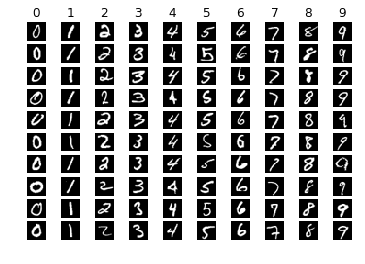

In [2]:
examples_per_class = 10
for cls in range(number_of_classes):
    idxs = np.where(y == cls)[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
        plt.imshow(x[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(str(cls))
plt.show()

## Mean and standard deviation

Compute and display the mean and variance of the grayscale value for each pixel for each digit.

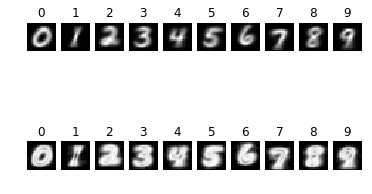

In [3]:
mean_of_class = np.zeros((10,20,20))
std_of_class = np.zeros((10,20,20))

for cls in range(number_of_classes):
    idxs = np.where(y == cls)[0]
    mean_of_class[cls] = np.mean(x[idxs],axis=0)
    std_of_class[cls] = np.std(x[idxs],axis=0)
    
    plt.subplot(2, number_of_classes, cls + 1)
    plt.imshow(mean_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
    
    plt.subplot(2, number_of_classes, number_of_classes+cls + 1)
    plt.imshow(std_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
plt.show()

## Generate Training and Testing data

  - Training set is 4000 images, 400 of each digit.
  - Test set is 1000 images, 100 of each digit.

Split into the following tensors:
  - x_train will contain the training data
  - y_train will contain the correct classes of the training data
  - x_test will contain the test data
  - y_test will contain the correct classes for the test data

In [4]:
x_train=np.zeros((4000,20,20))
y_train=np.zeros(4000)
x_test =np.zeros((1000,20,20))
y_test =np.zeros(1000)

for cls in range(number_of_classes):
    idx=cls*400
    idx1=cls*500
    idx2=cls*100
    x_train[idx:idx+400,:,:]=x[idx1:idx1+400,:,:]
    y_train[idx:idx+400]=y[idx1:idx1+400]
    x_test[idx2:idx2+100,:,:]=x[idx1+400:idx1+500,:,:]
    y_test[idx2:idx2+100]=y[idx1+400:idx1+500]

### Visualize train and test set to check consistency

Mean and standard deviation of each pixel for each digit in training set.

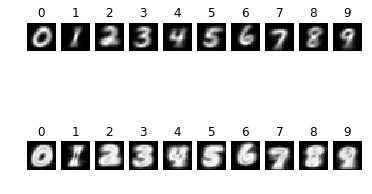

In [5]:
mean_of_class = np.zeros((10,20,20))

for cls in range(number_of_classes):
    idxs = np.where(y_train == cls)[0]
    mean_of_class[cls] = np.mean(x_train[idxs],axis=0)
    std_of_class[cls] = np.std(x_train[idxs],axis=0)
    
    plt.subplot(2, number_of_classes, cls + 1)
    plt.imshow(mean_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
    
    plt.subplot(2, number_of_classes, number_of_classes+cls + 1)
    plt.imshow(std_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
plt.show()

Mean and standard deviation of each pixel for each digit in test set.

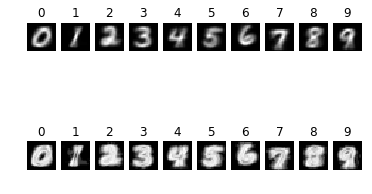

In [6]:
mean_of_class = np.zeros((10,20,20))

for cls in range(number_of_classes):
    idxs = np.where(y_test == cls)[0]
    mean_of_class[cls] = np.mean(x_test[idxs],axis=0)
    std_of_class[cls] = np.std(x_test[idxs],axis=0)
    
    plt.subplot(2, number_of_classes, cls + 1)
    plt.imshow(mean_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
    
    plt.subplot(2, number_of_classes, number_of_classes+cls + 1)
    plt.imshow(std_of_class[cls].astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.title(str(cls))
plt.show()

## Probability functions for Naïve Bayesian and NCC classifiers

$$p(x | y = i) = \prod_{i}p(x_{i} | y)$$
$$\Leftrightarrow$$
$$\log(\;p(x | y = i)\;) = \sum_{i}p(x_{i} | y)$$

$$\sum_{i}p(x_{i} | y) = -\frac{1}{2}\sum_{i=1}^{N}\log(2\pi\sigma_{i}^2)-\frac{1}{2}\sum_{i=1}^{N}\frac{(x_{i} - \mu_{i})^2}{\sigma_{i}^2}$$

In [7]:
import math

def calculateProbability(x, mean, std):
    prob = 0 
    rows, cols = x.shape
    for i in range(rows):
        for j in range(cols):
            # Use the logarithmic version and add the results instead of multiplying them
            prob += -0.5*math.pow(((x[i][j]-mean[i][j])/std[i][j]),2)-math.log(std[i][j]*math.sqrt(2*math.pi))
    return prob


# Just calculateProbability with standard deviation set to one.
def calcNCCprob(x, mean):
    prob = 0 
    rows, cols = x.shape
    for i in range(rows):
        for j in range(cols):
            prob += -0.5*math.pow(((x[i][j]-mean[i][j])),2)-math.log(math.sqrt(2*math.pi))
    return prob

## Functions for predicting the most likely digit

In [8]:
std_of_class = np.zeros((10,20,20))
mean_of_class = np.zeros((10,20,20))

for cls in range(number_of_classes):
    idxs = np.where(y_train == cls)[0]
    mean_of_class[cls] = np.mean(x_train[idxs],axis=0)
    std_of_class[cls] = np.std(x_train[idxs], axis=0)+1 # Plus one in order to avoid dividing by zero


def NaiveBayesian(x_test):
    y_test_pred = np.zeros(len(x_test)) # Could use shape here instead.
    for i in range(len(x_test)):
        digit_probs = np.ones(number_of_classes) # Save prob for each digit in current test case here.
        for j in range(number_of_classes):
            digit_probs[j] = calculateProbability(x_test[i], mean_of_class[j], std_of_class[j])
        y_test_pred[i] = np.argmax(digit_probs) # Choose most likely digit.
    return y_test_pred


def NCC(x_test):
    y_test_pred = np.zeros(len(x_test))
    for i in range(len(x_test)):
        digit_probs = np.ones(number_of_classes)
        for j in range(number_of_classes):
            digit_probs[j] = calcNCCprob(x_test[i], mean_of_class[j])
        y_test_pred[i] = np.argmax(digit_probs)
    return y_test_pred

## Evaluate accuracy

For the Naïve Bayesian classifier.

In [9]:
y_test_pred = NaiveBayesian(x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Accuracy: %f.' % test_accuracy)
print('Correct: %d.' % sum(y_test == y_test_pred))
print('Incorrect: %d.' % (len(y_test) - sum(y_test == y_test_pred)))

Accuracy: 0.704000.
Correct: 704.
Incorrect: 296.


For the NCC classifier.

In [10]:
y_test_pred_ncc = NCC(x_test)
test_accuracy = np.mean(y_test == y_test_pred_ncc)
print('Accuracy: %f.' % test_accuracy)
print('Correct: %d.' % sum(y_test == y_test_pred_ncc))
print('Incorrect: %d.' % (len(y_test) - sum(y_test == y_test_pred_ncc)))

Accuracy: 0.796000.
Correct: 796.
Incorrect: 204.


## Visualize some of the incorrectly classified test samples

For the Naïve Bayesian classifier.

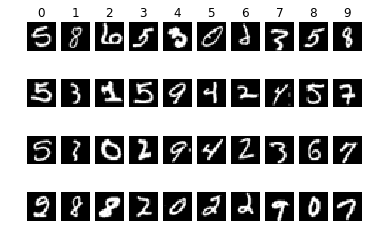

In [11]:
examples_per_class = 4
for cls in range(number_of_classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
        plt.imshow(x_test[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(str(cls))
plt.show()

For the NCC classifier.

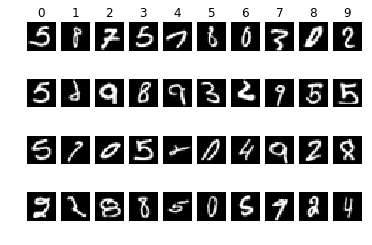

In [12]:
examples_per_class = 4
for cls in range(number_of_classes):
    idxs = np.where((y_test != cls) & (y_test_pred_ncc == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
        plt.imshow(x_test[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(str(cls))
plt.show()